In [ ]:
!pip install tpot

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the curren

In [3]:
from sklearn.model_selection import train_test_split
from __future__ import print_function
import sys,tempfile, urllib, os
import pandas as pd
import numpy as np

In [11]:
train=  pd.read_csv("/content/train.csv")
test= pd.read_csv("/content/test.csv")

In [12]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [13]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# From EDA obvious outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])


print (train.columns)
print(test.columns)
print(train.shape,test.shape)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Skewness: 1.890792
Kurtosis: 6.557511


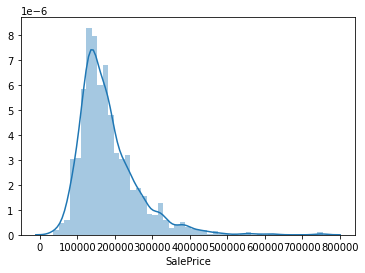

In [14]:
train['SalePrice'].describe()
sns.distplot(train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


 mu = 181268.63 and sigma = 79370.09


 mu = 12.03 and sigma = 0.40



Text(0.5, 0.98, 'After transformation')

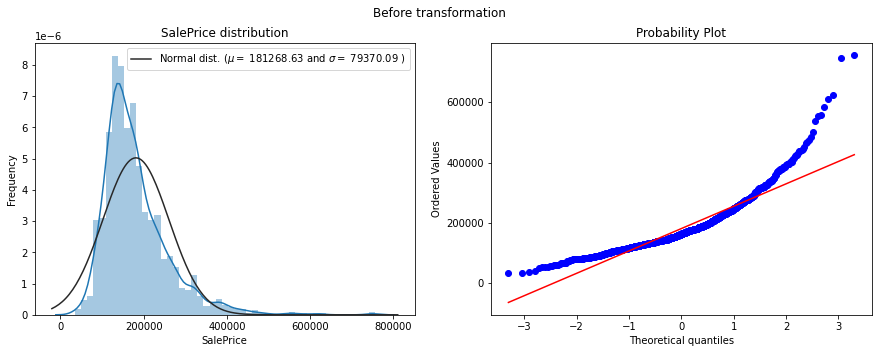

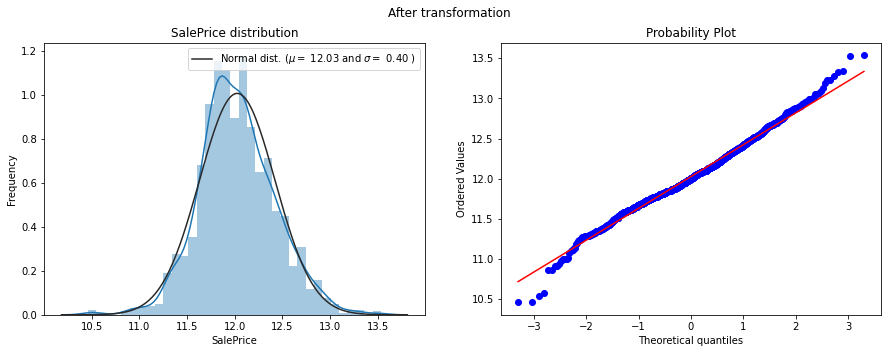

In [15]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('Before transformation')

# Apply transformation
train.SalePrice = np.log1p(train.SalePrice )
# New prediction
y_train = train.SalePrice.values
y_train_orig = train.SalePrice


# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('After transformation')

In [16]:
data_features = pd.concat((train, test)).reset_index(drop=True)
print(data_features.shape)


(2912, 80)


In [17]:
data_features_na = data_features.isnull().sum()
data_features_na = data_features_na[data_features_na>0]
data_features_na.sort_values(ascending=False)

PoolQC          2903
MiscFeature     2807
Alley           2715
Fence           2344
SalePrice       1459
FireplaceQu     1418
LotFrontage      486
GarageYrBlt      158
GarageFinish     158
GarageQual       158
GarageCond       158
GarageType       156
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

In [18]:
#missing data percent plot
total = data_features.isnull().sum().sort_values(ascending=False)
percent = (data_features.isnull().sum()/data_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2903,0.996909
MiscFeature,2807,0.963942
Alley,2715,0.932349
Fence,2344,0.804945
SalePrice,1459,0.501030
FireplaceQu,1418,0.486951
LotFrontage,486,0.166896
GarageCond,158,0.054258
GarageYrBlt,158,0.054258
GarageQual,158,0.054258


In [19]:
str_vars = ['MSSubClass','YrSold','MoSold']
for var in str_vars:
    data_features[var] = data_features[var].apply(str)

In [20]:
common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for var in common_vars:
    data_features[var] = data_features[var].fillna(data_features[var].mode()[0])
    
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
data_features['MSZoning'] = data_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [21]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    data_features[col] = data_features[col].fillna('None')
# # For all these categorical basement-related features, NaN means that there is no basement
# for col in (:
#     features[col] = features[col].fillna('None')

In [22]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    data_features[col] = data_features[col].fillna(0)

# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data_features['LotFrontage'] = data_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', data_features.shape)

Features size: (2912, 80)


In [23]:
data_features['Functional'] = data_features['Functional'].fillna('Typ')

In [24]:
total = data_features.isnull().sum().sort_values(ascending=False)
percent = (data_features.isnull().sum()/data_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
SalePrice,1459,0.50103
SaleCondition,0,0.00000
RoofMatl,0,0.00000
Exterior1st,0,0.00000
Exterior2nd,0,0.00000
MasVnrType,0,0.00000
MasVnrArea,0,0.00000
ExterQual,0,0.00000
ExterCond,0,0.00000
Foundation,0,0.00000


In [25]:
categorical_features = data_features.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = data_features.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = data_features[numerical_features]
feat_cat = data_features[categorical_features]

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'B

In [26]:
from scipy.stats import skew 
skewness = feat_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          21.920854
PoolArea         17.673354
LotArea          13.099125
LowQualFinSF     12.391544
3SsnPorch        11.362112
KitchenAbvGr      4.296287
BsmtFinSF2        4.145924
EnclosedPorch     4.029556
ScreenPorch       3.941117
BsmtHalfBath      3.925998
MasVnrArea        2.624575
OpenPorchSF       2.527454
WoodDeckSF        1.844011
1stFlrSF          1.259015
LotFrontage       1.105058
GrLivArea         1.068478
BsmtFinSF1        0.980559
BsmtUnfSF         0.919505
2ndFlrSF          0.860245
TotRmsAbvGrd      0.747869
Fireplaces        0.726054
HalfBath          0.693943
TotalBsmtSF       0.672246
BsmtFullBath      0.619682
OverallCond       0.578748
BedroomAbvGr      0.325821
GarageArea        0.217763
OverallQual       0.191839
FullBath          0.164972
GarageCars       -0.219219
YearRemodAdd     -0.451505
YearBuilt        -0.600202
GarageYrBlt      -3.915227
SalePrice              NaN
dtype: float64

In [27]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    feat_num[feat] = boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))
    data_features[feat] = boxcox1p(data_features[feat], boxcox_normmax(data_features[feat] + 1))
    
    
from scipy.stats import skew 
skewness.sort_values(ascending=False)

There are 27 skewed numerical features to Box Cox transform
Mean skewnees: 4.055477203766242


MiscVal          21.920854
PoolArea         17.673354
LotArea          13.099125
LowQualFinSF     12.391544
3SsnPorch        11.362112
KitchenAbvGr      4.296287
BsmtFinSF2        4.145924
EnclosedPorch     4.029556
ScreenPorch       3.941117
BsmtHalfBath      3.925998
MasVnrArea        2.624575
OpenPorchSF       2.527454
WoodDeckSF        1.844011
1stFlrSF          1.259015
LotFrontage       1.105058
GrLivArea         1.068478
BsmtFinSF1        0.980559
BsmtUnfSF         0.919505
2ndFlrSF          0.860245
TotRmsAbvGrd      0.747869
Fireplaces        0.726054
HalfBath          0.693943
TotalBsmtSF       0.672246
BsmtFullBath      0.619682
OverallCond       0.578748
YearBuilt        -0.600202
GarageYrBlt      -3.915227
dtype: float64

In [28]:
skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

There are 17 skewed numerical features after Box Cox transform
Mean skewnees: 3.50484225910873


PoolArea         15.581589
3SsnPorch         8.854291
LowQualFinSF      8.598260
MiscVal           5.233200
BsmtHalfBath      3.775618
KitchenAbvGr      3.774434
ScreenPorch       3.149430
BsmtFinSF2        2.580032
EnclosedPorch     2.156781
MasVnrArea        0.977673
2ndFlrSF          0.894364
WoodDeckSF        0.784470
HalfBath          0.730155
GarageYrBlt       0.703539
OpenPorchSF       0.620616
BsmtFullBath      0.614203
Fireplaces        0.553660
dtype: float64

In [29]:
data_features['TotalSF']=data_features['TotalBsmtSF'] + data_features['1stFlrSF'] + data_features['2ndFlrSF']
#  Adding total bathrooms feature
data_features['Total_Bathrooms'] = (data_features['FullBath'] + (0.5 * data_features['HalfBath']) +
                               data_features['BsmtFullBath'] + (0.5 * data_features['BsmtHalfBath']))
#  Adding total porch sqfootage feature
data_features['Total_porch_sf'] = (data_features['OpenPorchSF'] + data_features['3SsnPorch'] +
                              data_features['EnclosedPorch'] + data_features['ScreenPorch'] +
                              data_features['WoodDeckSF'])


In [30]:
data_features['haspool'] = data_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasgarage'] = data_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasbsmt'] = data_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data_features['hasfireplace'] = data_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
data_features = data_features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1)
# data_features = data_features.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF',
#                          'PoolArea','3SsnPorch','LowQualFinSF','MiscVal','BsmtHalfBath','ScreenPorch',
#                          'ScreenPorch','KitchenAbvGr','BsmtFinSF2','EnclosedPorch','LotFrontage'
#                          ,'BsmtUnfSF','GarageYrBlt'], axis=1)

print('data_features size:', data_features.shape)

data_features size: (2912, 82)


In [32]:
train = data_features.iloc[:len(y_train), :]
test = data_features.iloc[len(y_train):, :]
print(['Train data shpe: ',train.shape,'Prediction on (Sales price) shape: ', y_train.shape,'Test shape: ', test.shape])

['Train data shpe: ', (1453, 82), 'Prediction on (Sales price) shape: ', (1453,), 'Test shape: ', (1459, 82)]


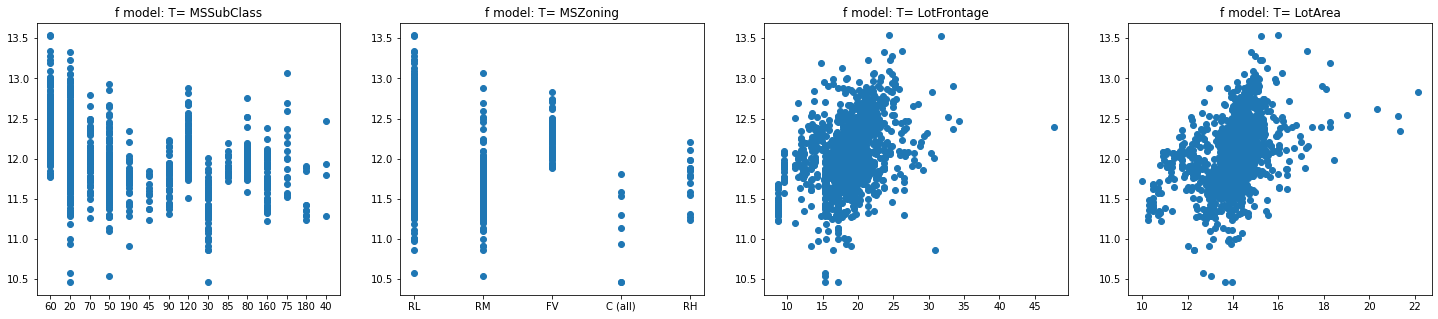

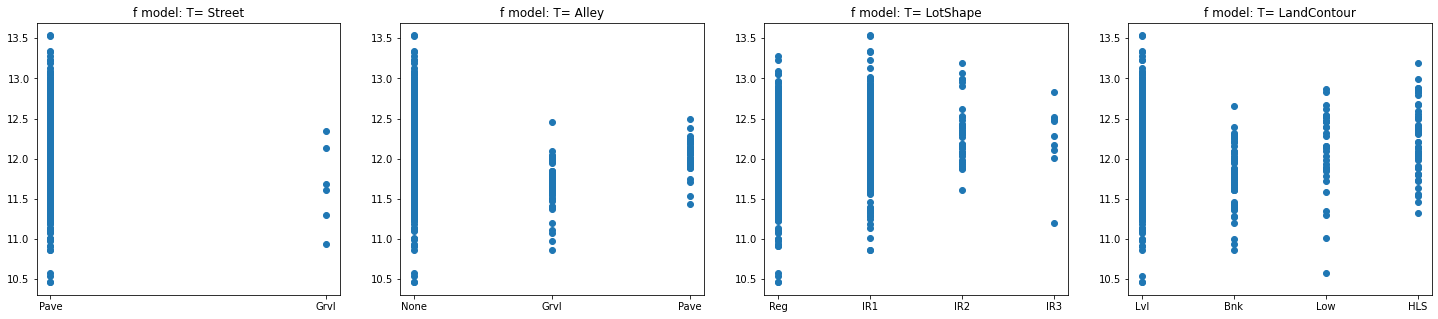

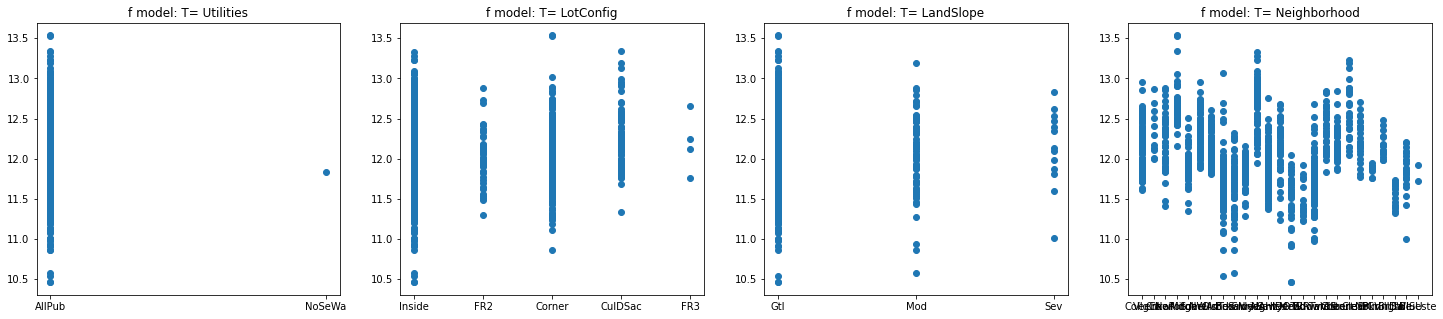

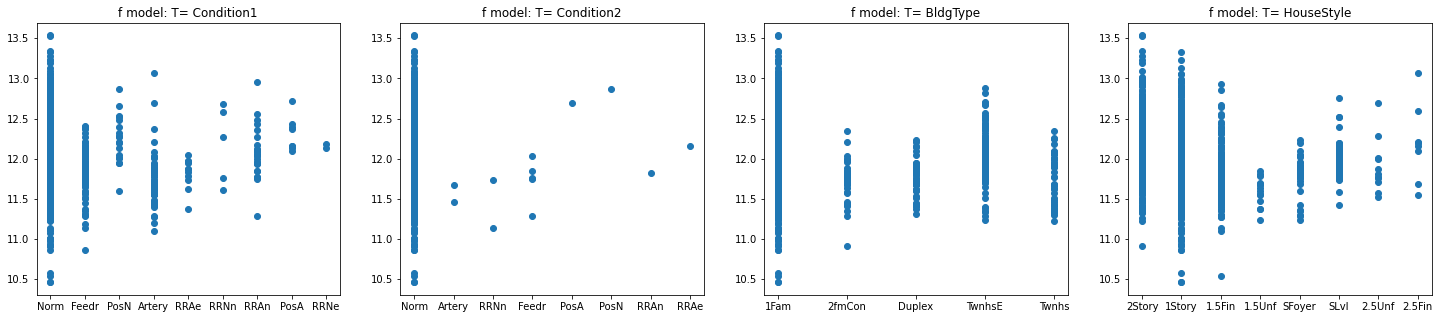

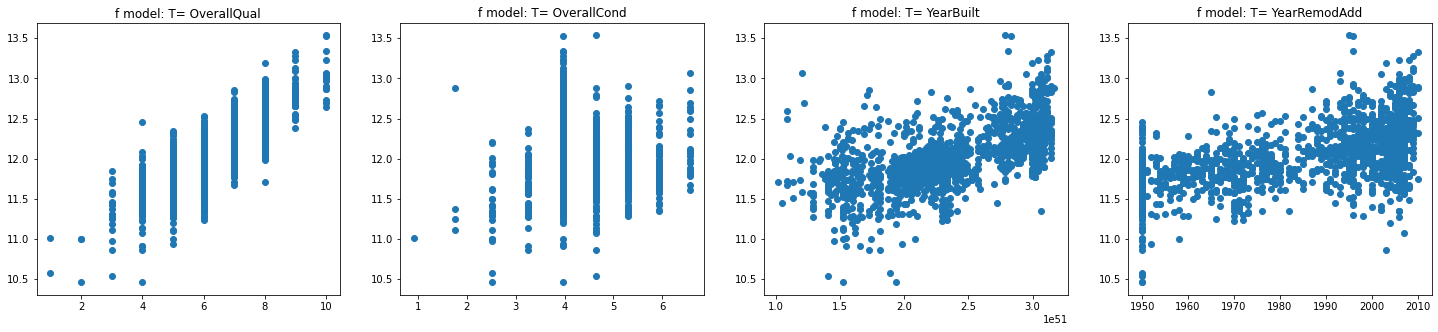

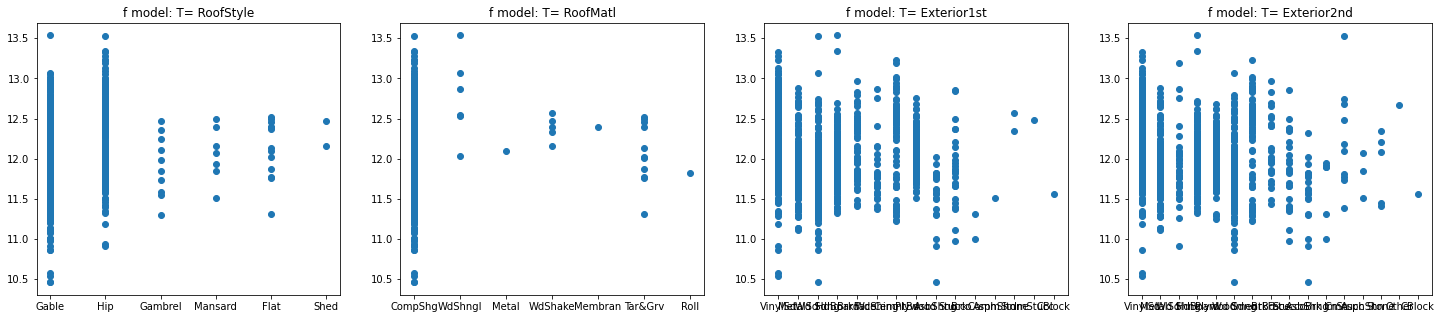

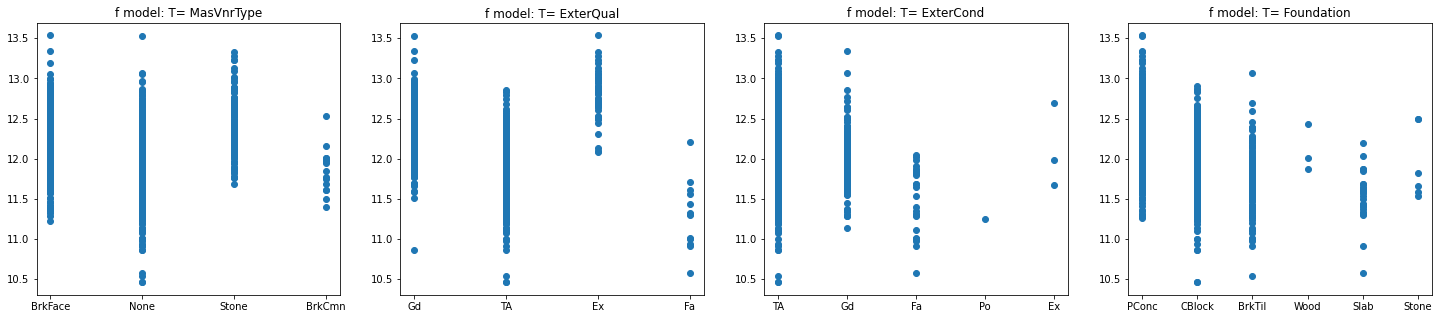

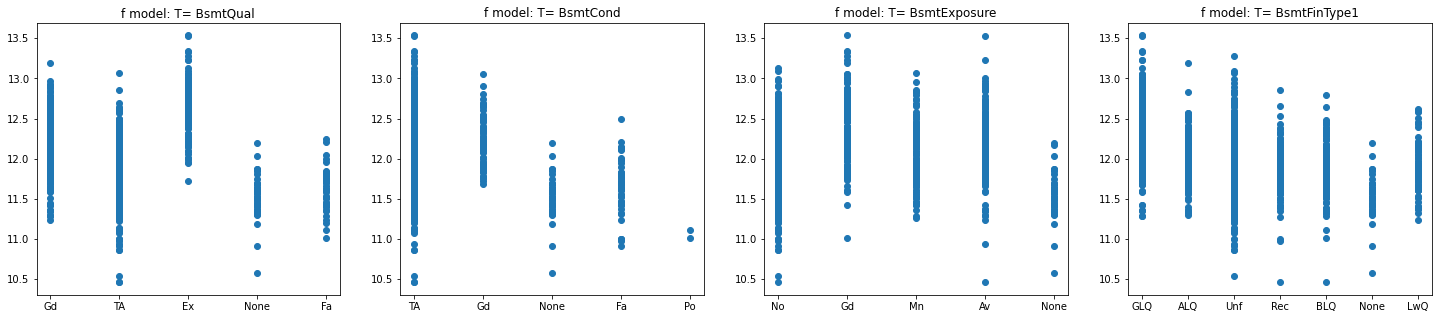

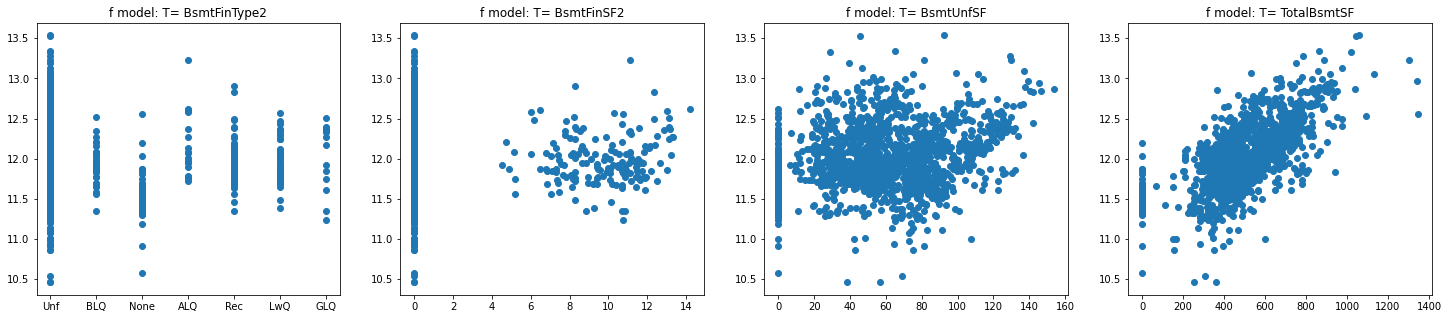

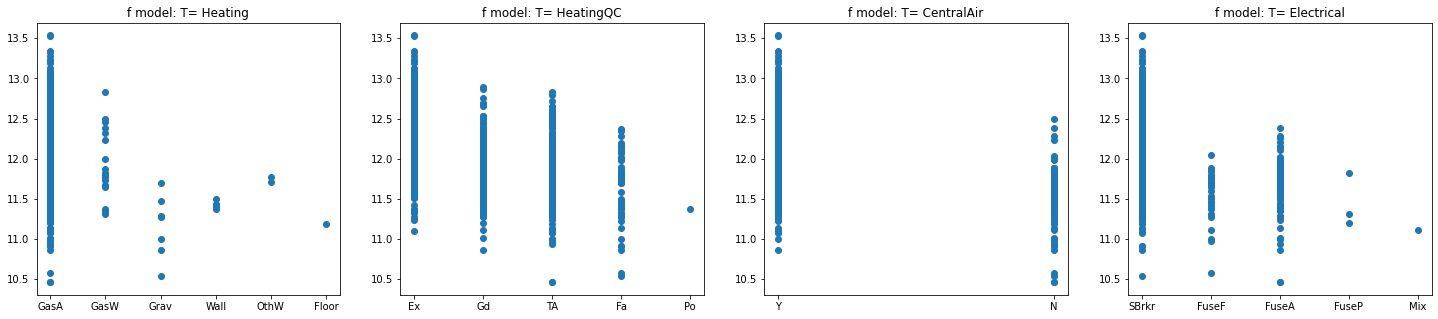

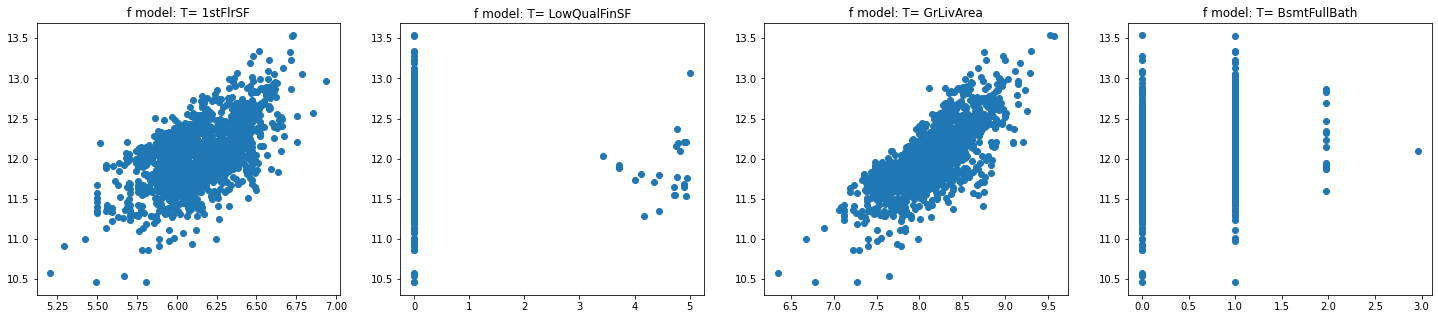

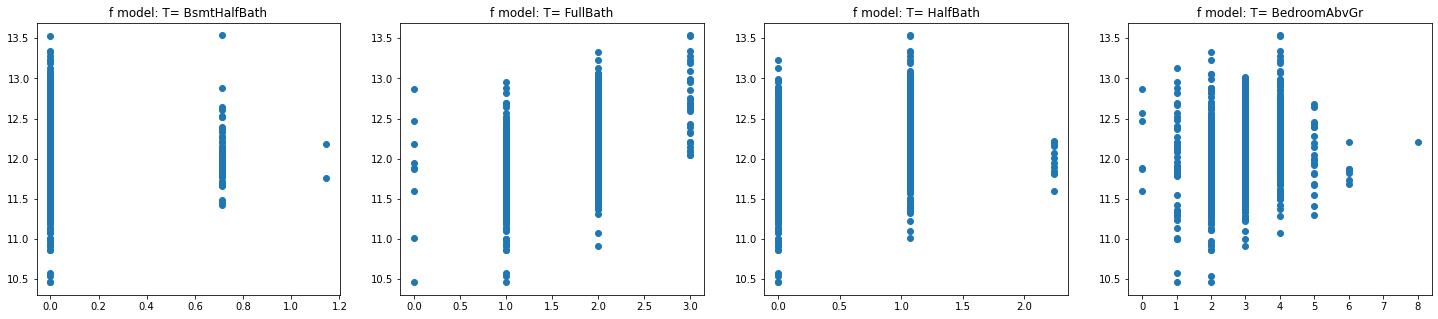

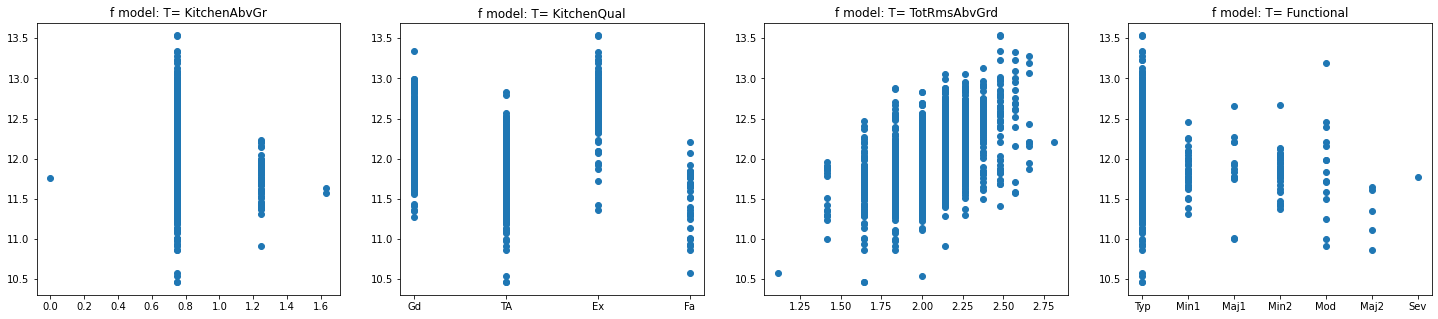

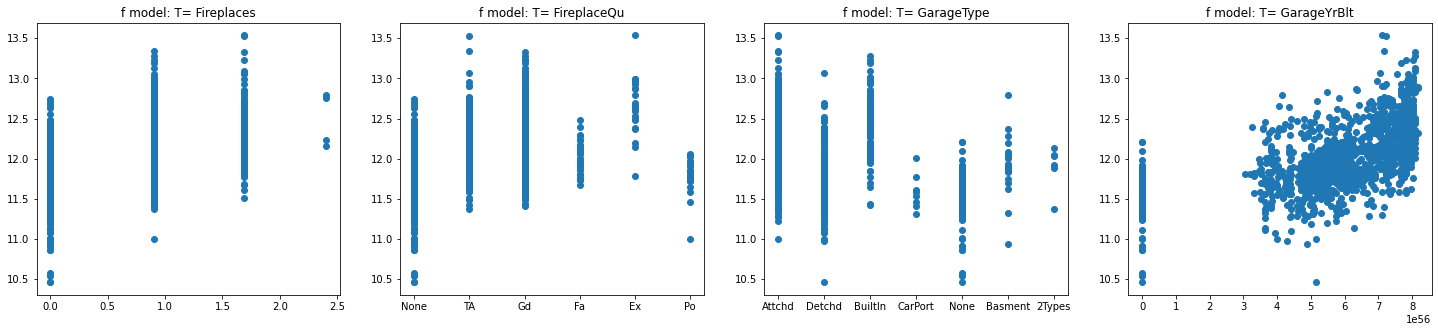

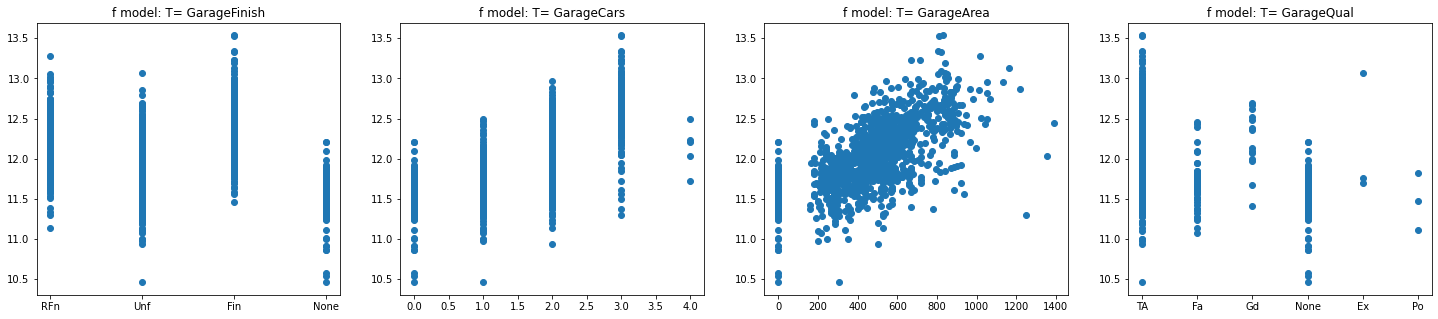

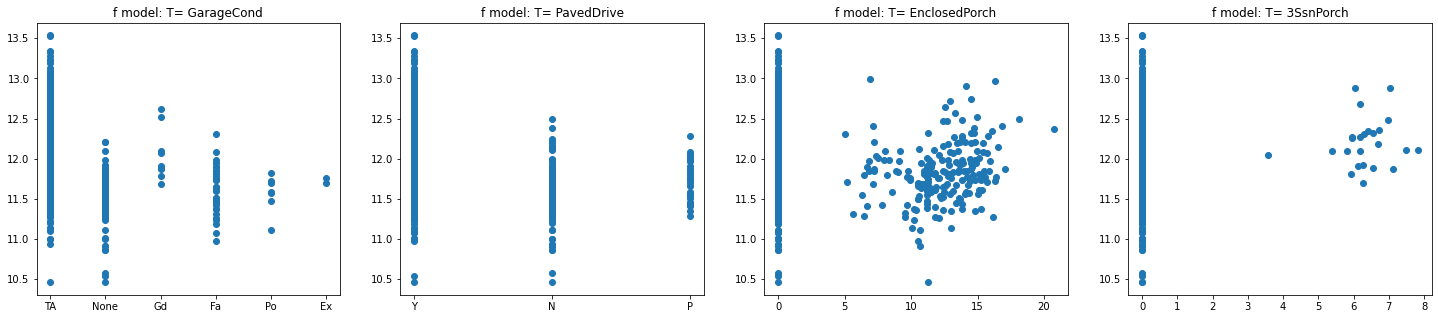

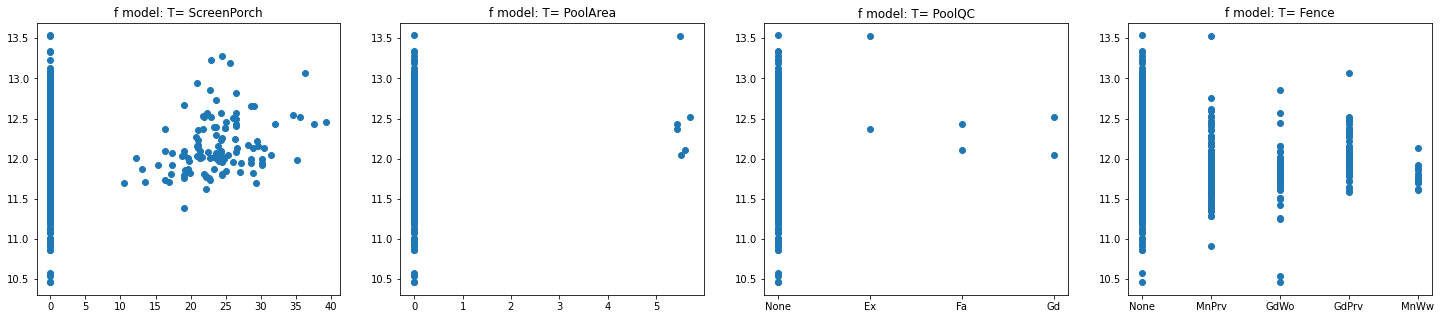

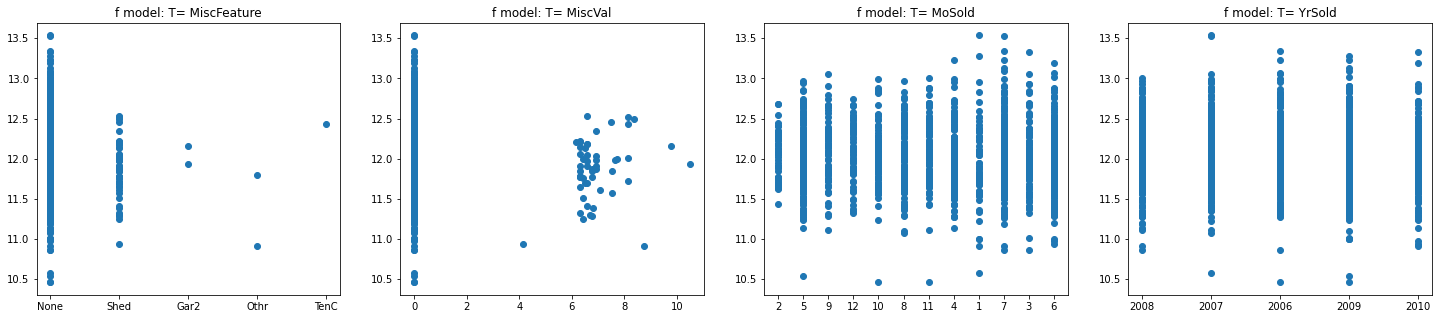

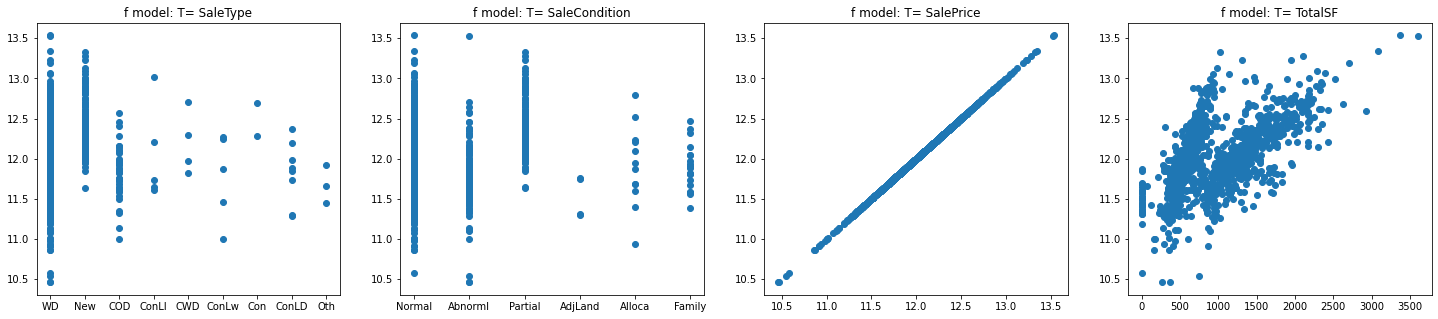

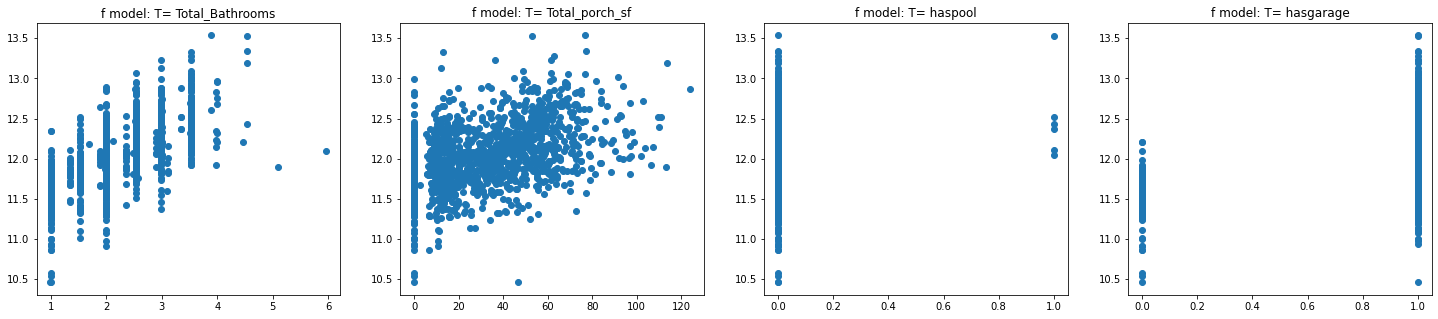

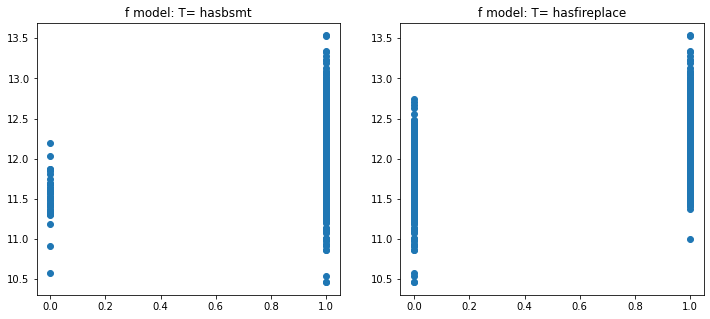

In [33]:
vars = data_features.columns
# vars = numerical_features
figures_per_time = 4
count = 0 
y = y_train
for var in vars:
    x = train[var]
#     print(y.shape,x.shape)
    plt.figure(count//figures_per_time,figsize=(25,5))
    plt.subplot(1,figures_per_time,np.mod(count,4)+1)
    plt.scatter(x, y);
    plt.title('f model: T= {}'.format(var))
    count+=1
    

In [35]:
# Removes outliers 
# outliers = [30, 88, 462, 631, 1322]
# train = train.drop(train.index[outliers])
y_train = train['SalePrice']

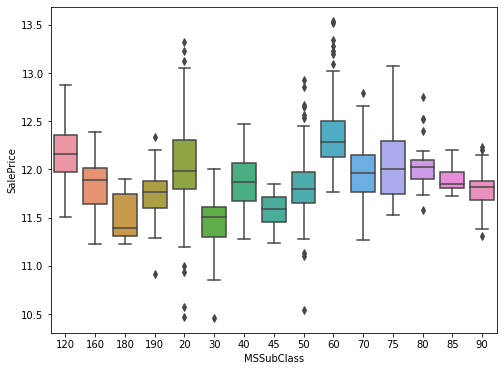

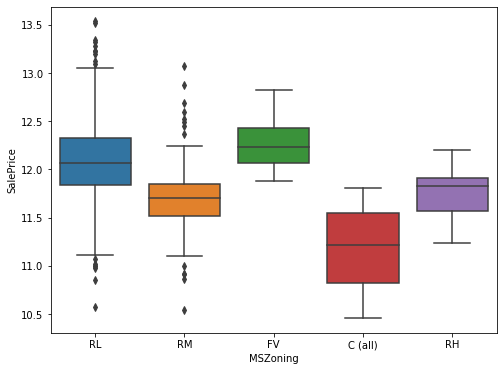

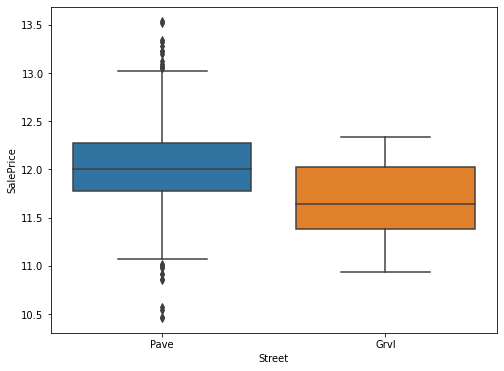

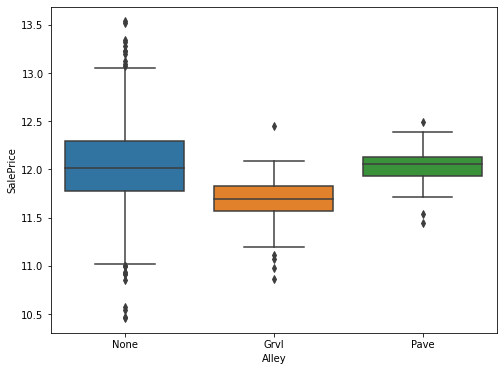

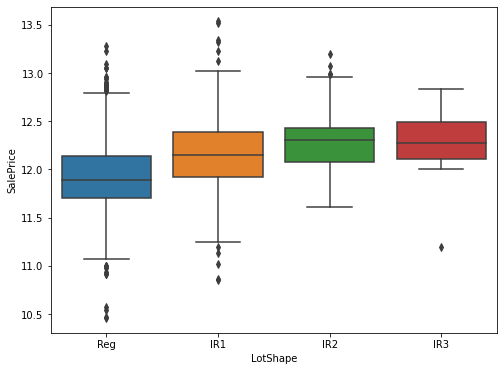

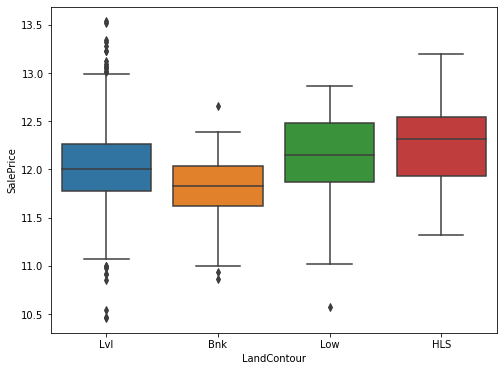

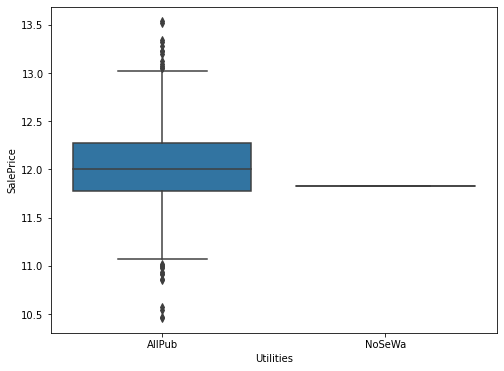

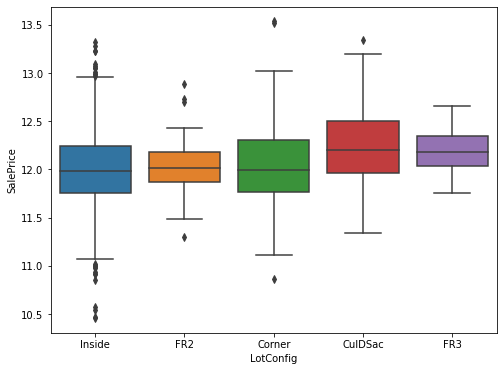

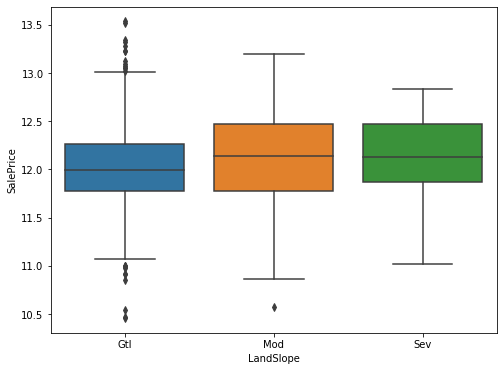

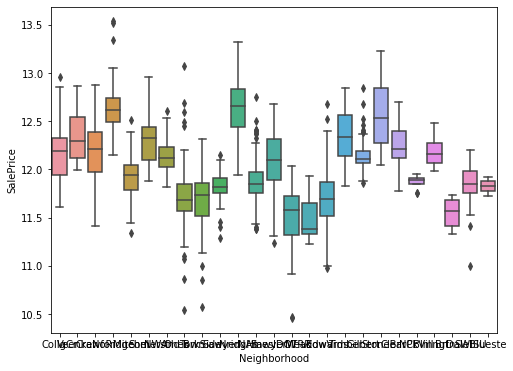

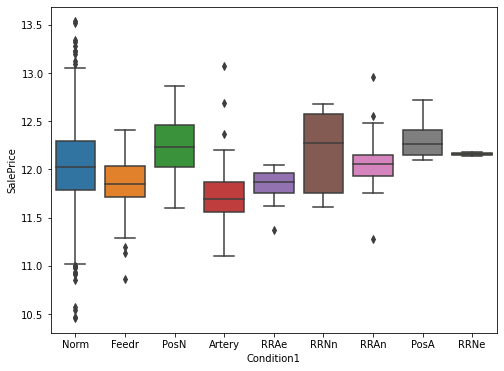

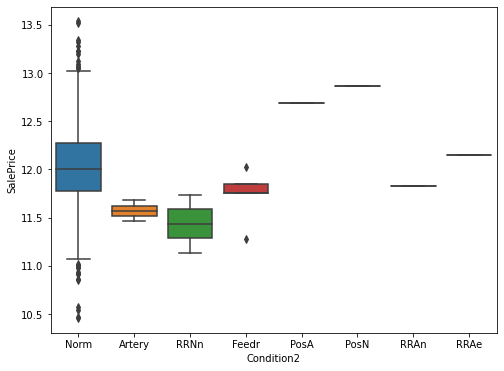

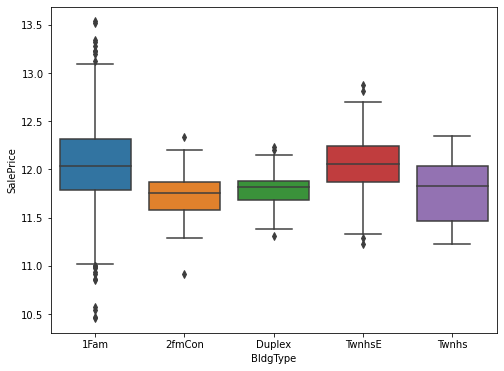

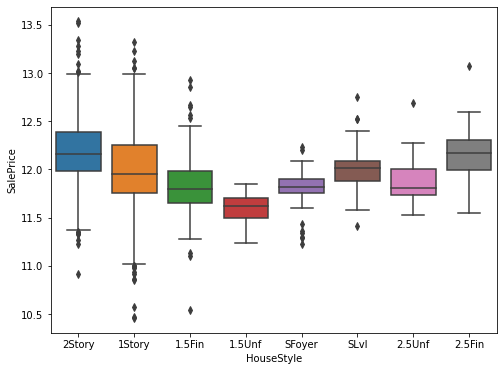

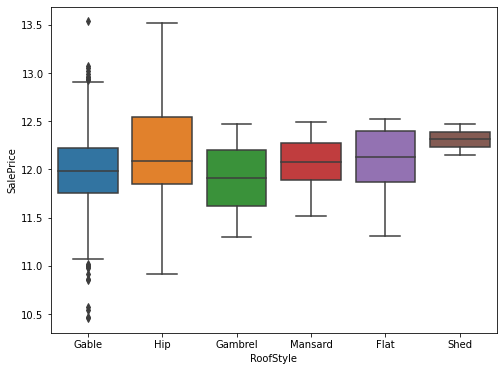

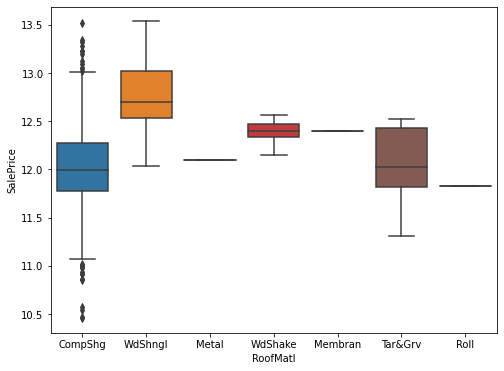

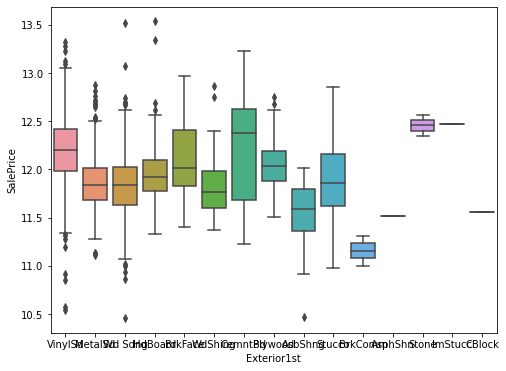

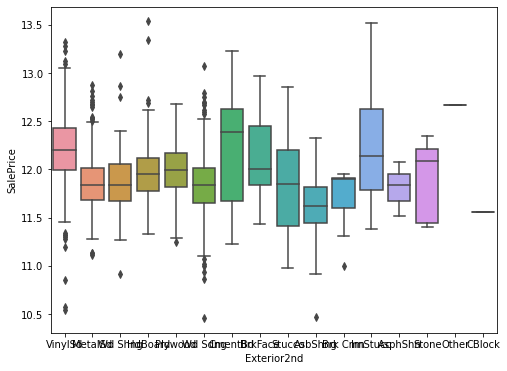

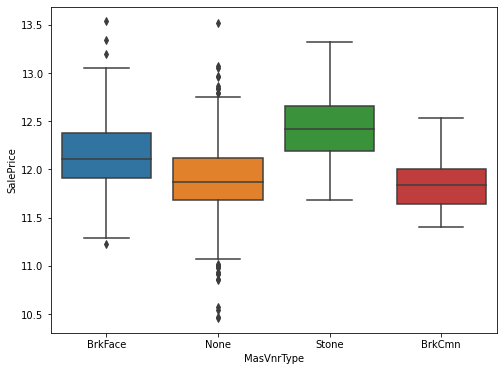

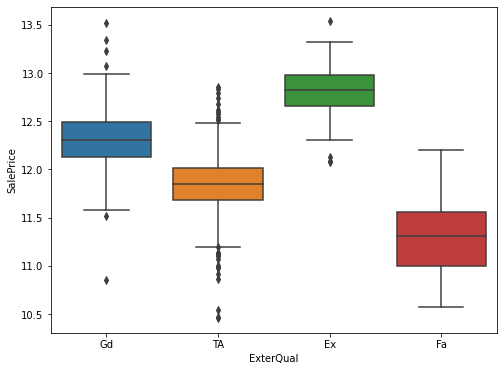

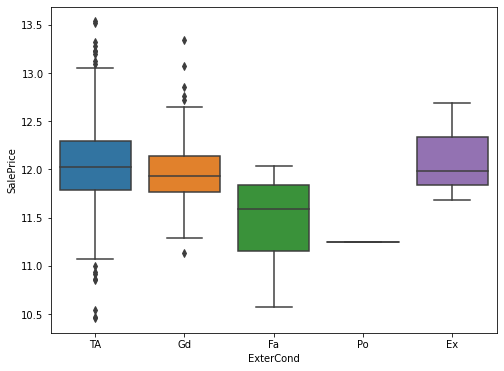

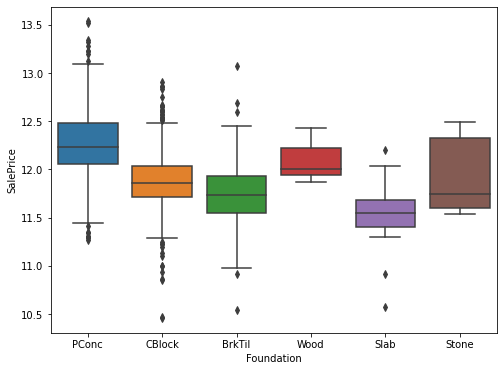

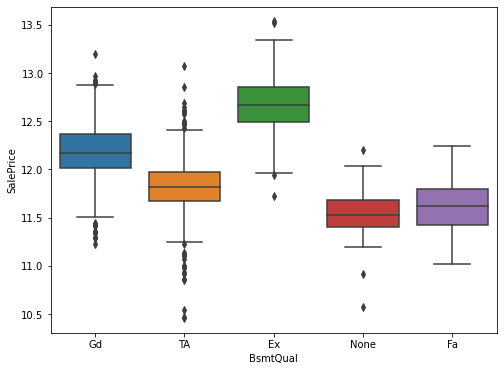

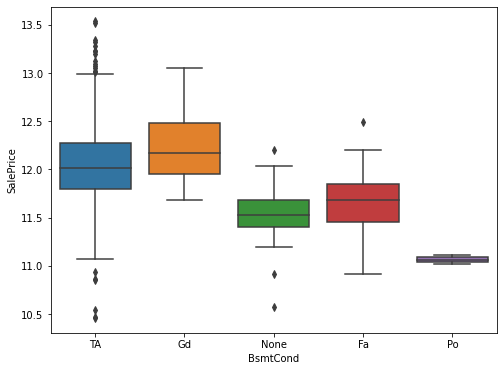

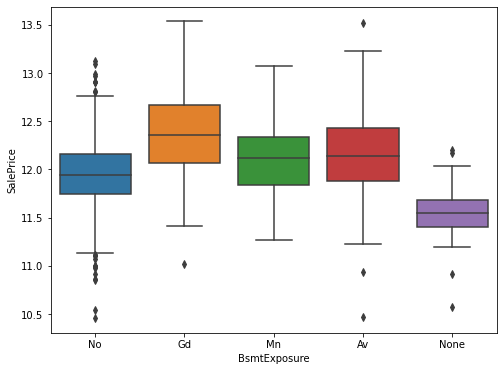

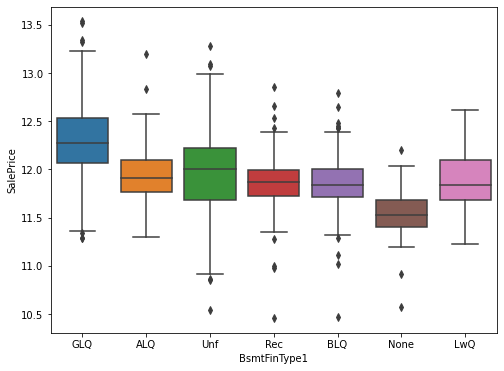

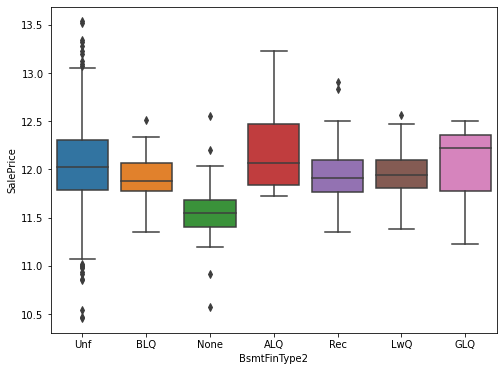

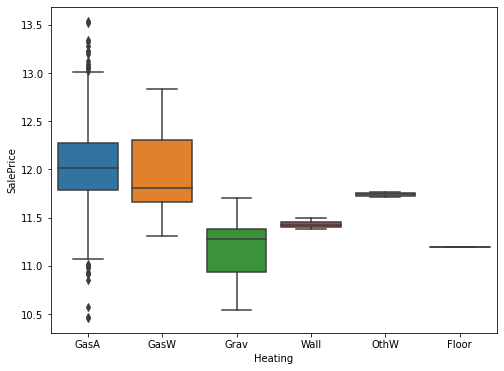

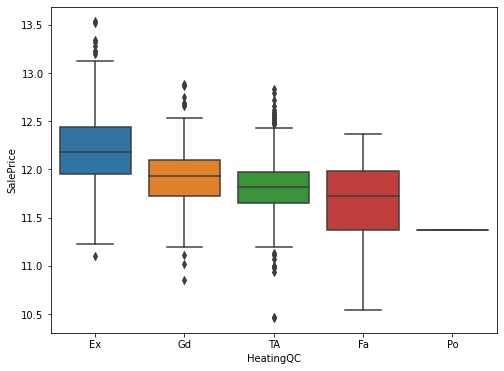

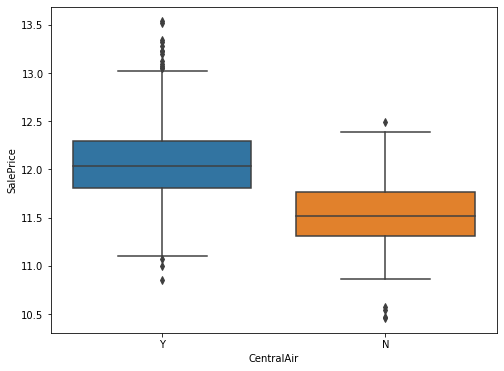

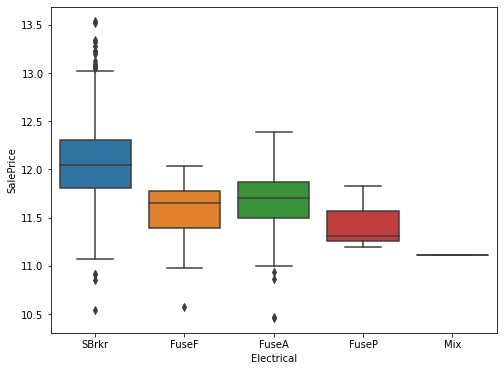

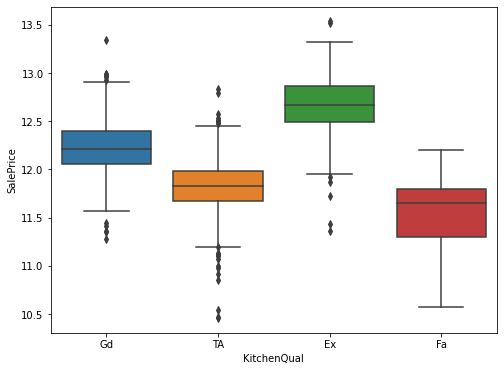

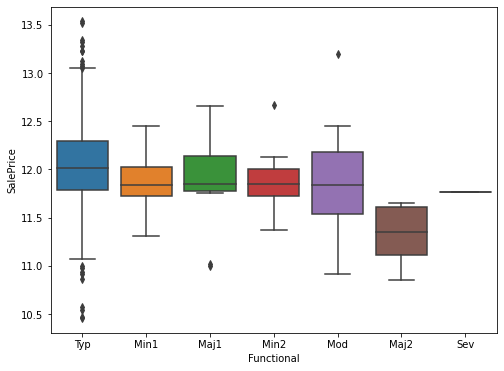

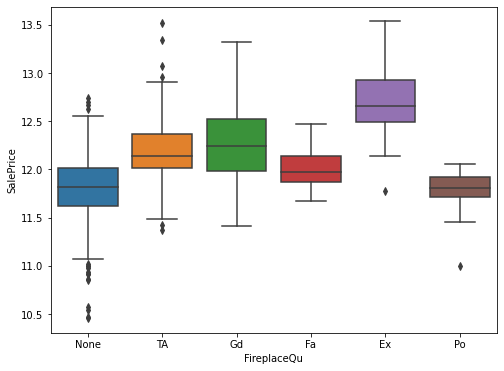

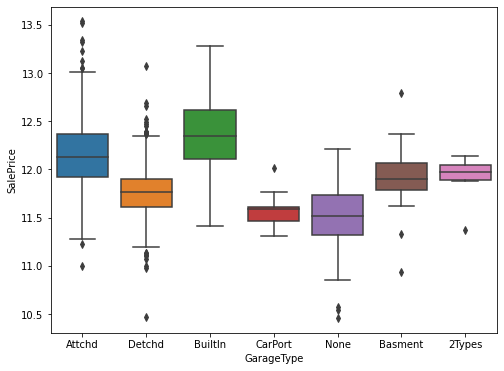

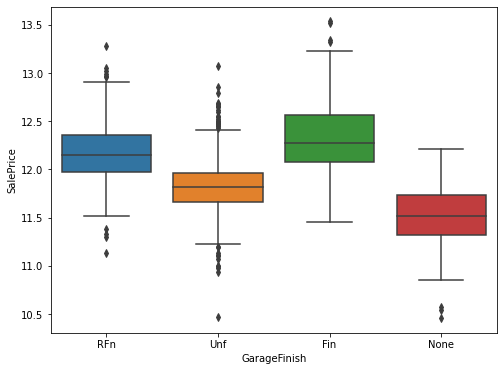

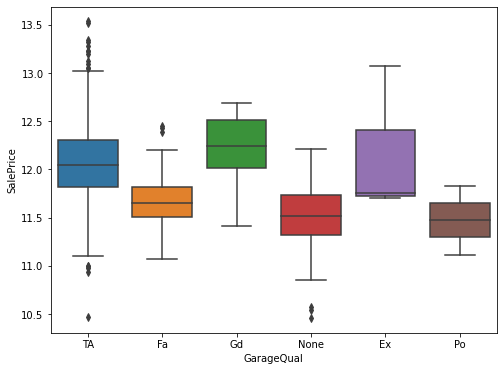

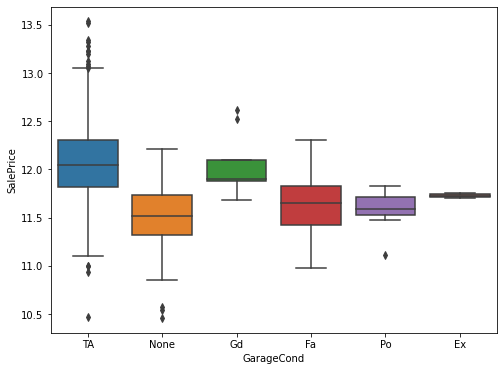

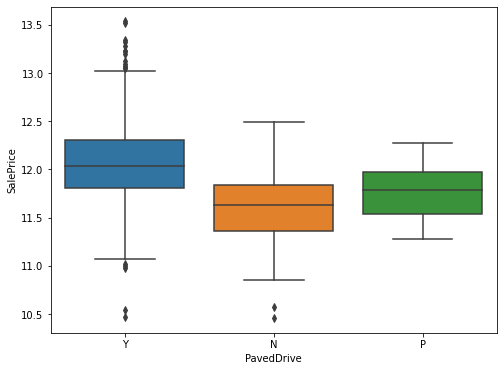

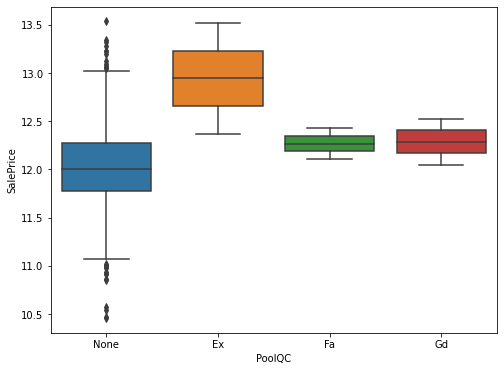

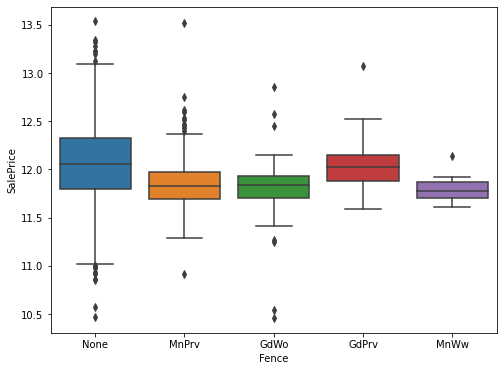

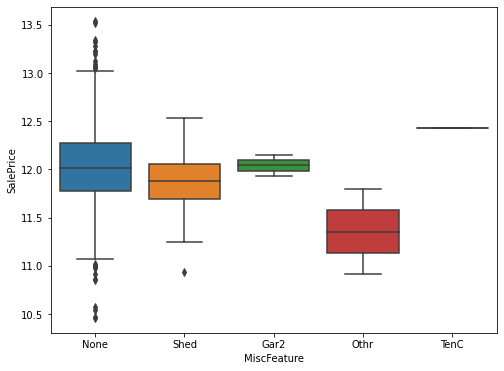

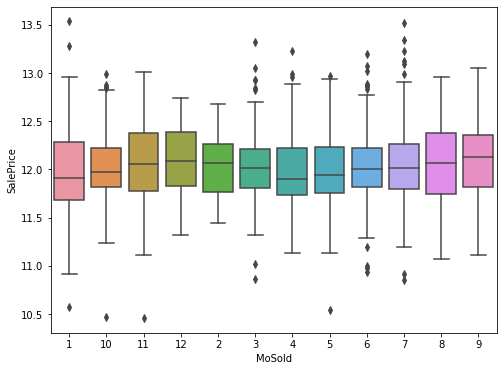

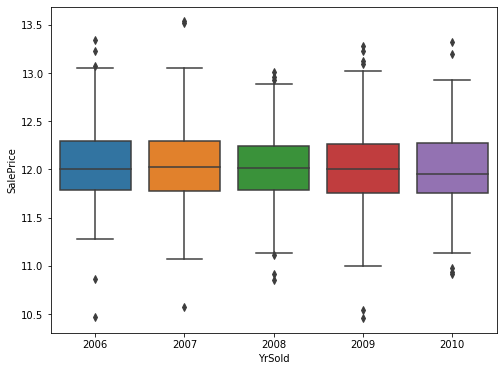

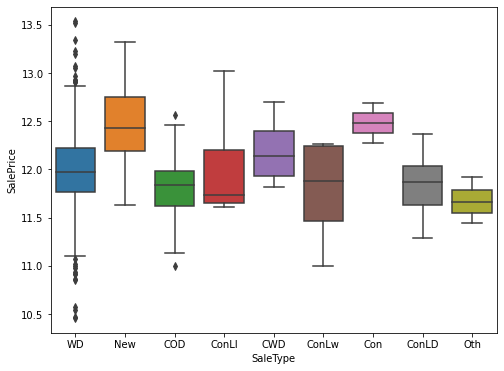

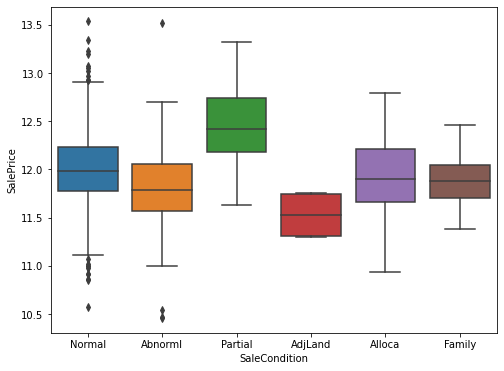

In [36]:
vars_box = feat_cat
for var in vars_box:
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)

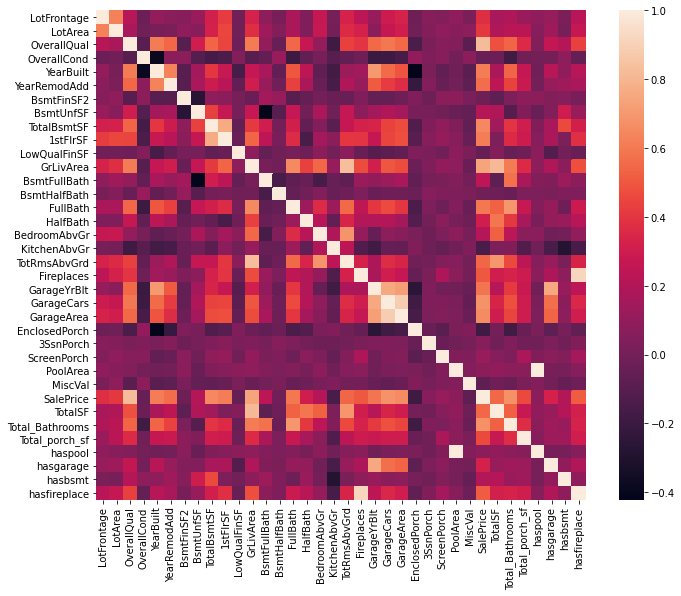

In [37]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

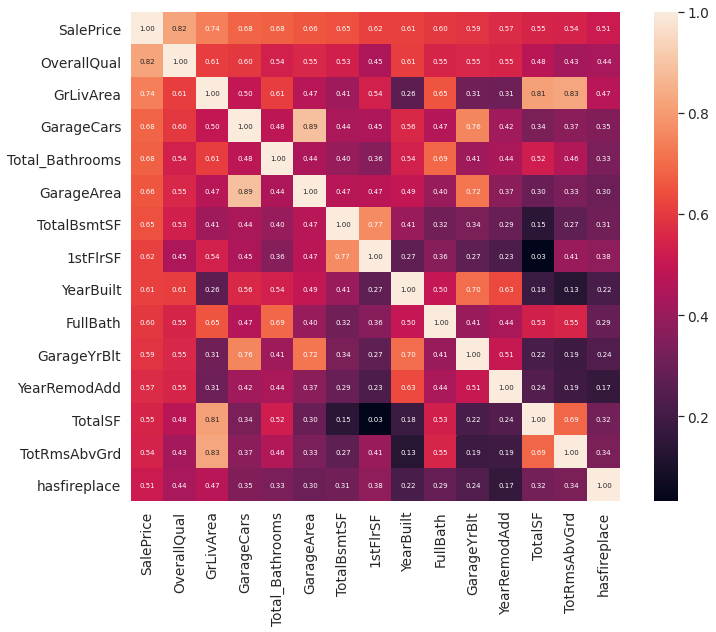

In [38]:
corr_num = 15 #number of variables for heatmap
cols_corr = corrmat.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train[cols_corr].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corr_mat_sales, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()

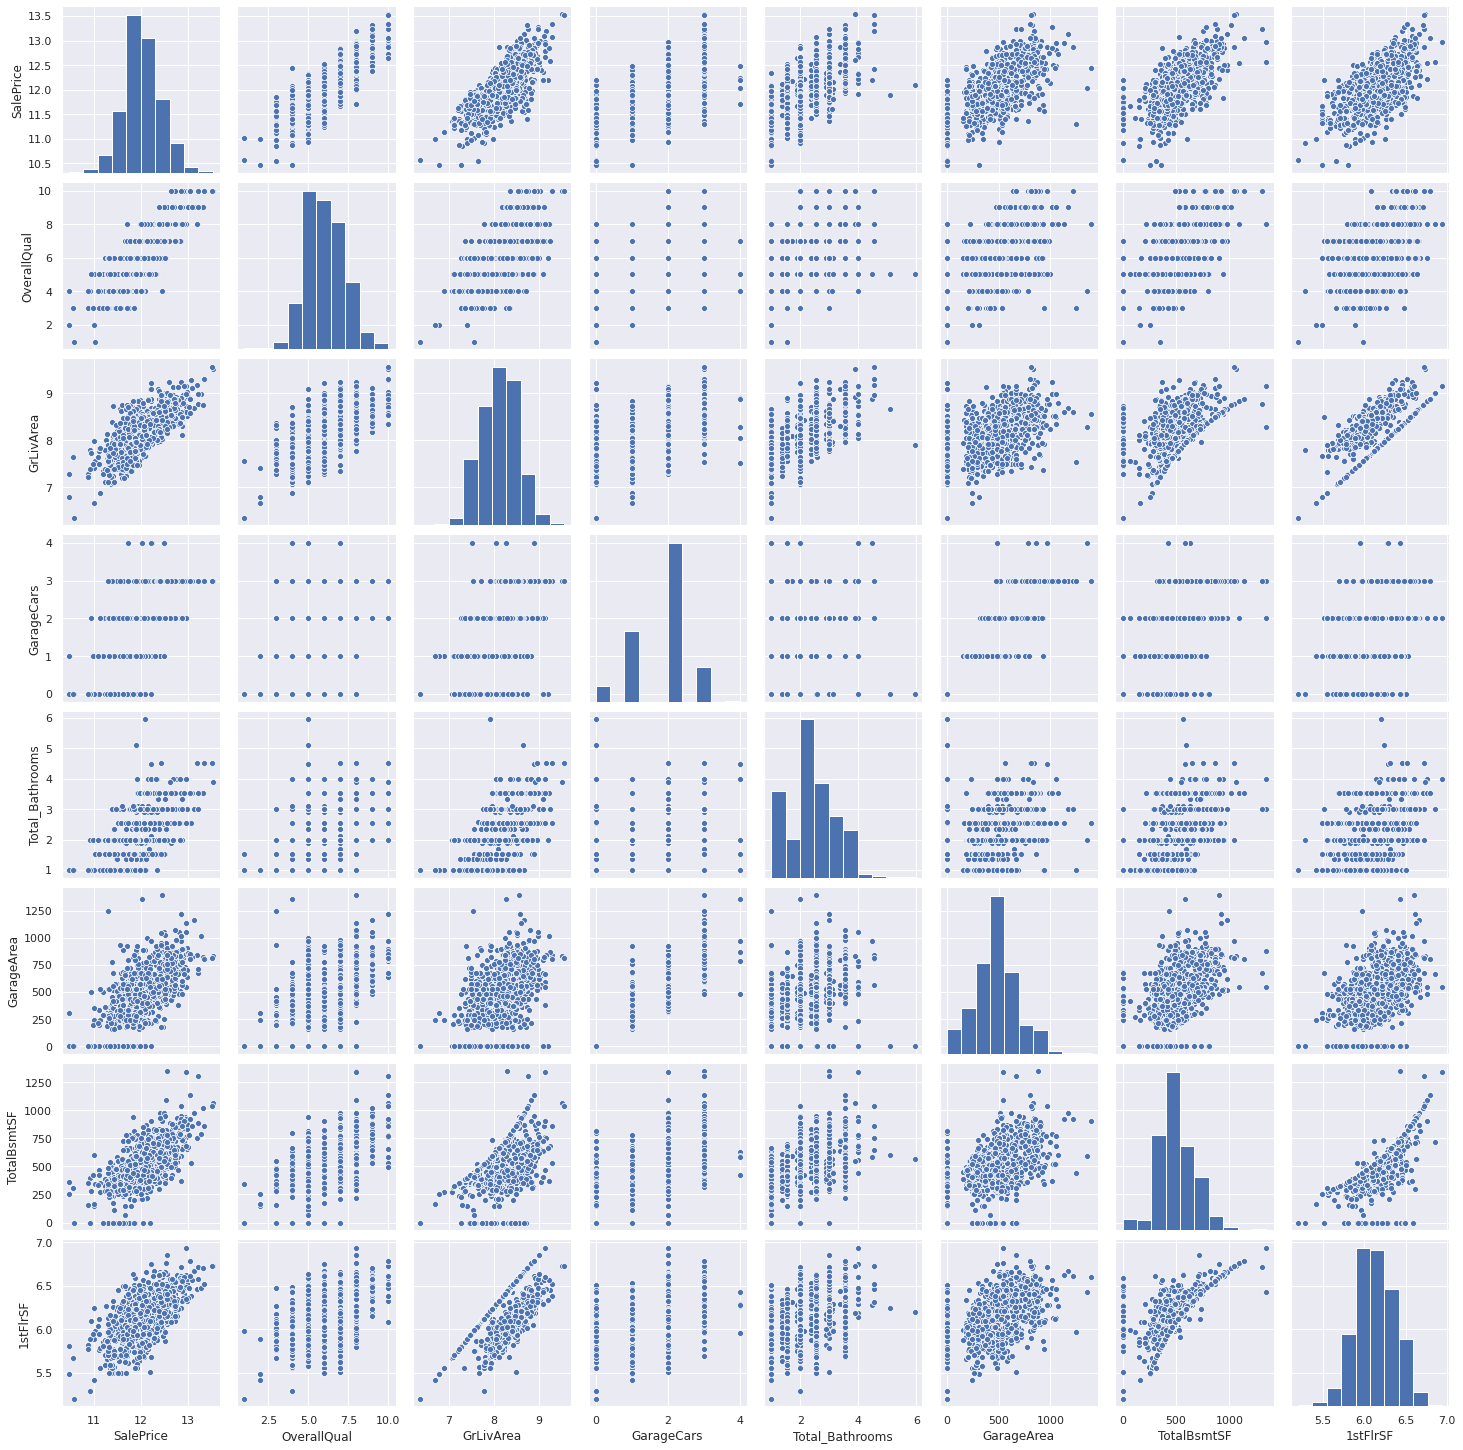

In [39]:
var_num = 8
vars = cols_corr[0:var_num]

sns.set()
sns.pairplot(train[vars], size = 2.5)
plt.show();

In [40]:
data_features = data_features.drop("SalePrice", axis = 1)
final_features = pd.get_dummies(data_features)

print(final_features.shape)
X = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(y):, :]
X.shape, y_train.shape, X_test.shape


print(X.shape,y_train.shape,X_test.shape)

(2912, 334)
(1453, 334) (1453,) (1459, 334)


In [41]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print(X.shape,y_train.shape,X_test.shape)

(1453, 331) (1453,) (1459, 331)


In [42]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [43]:
kfolds = KFold(n_splits=18, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [44]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=9000, #8000
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2, # 'was 0.2'
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)



# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]




# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)


svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm,
          'Svd': svr}
#           'xgboost': xgboost}
predictions = {}
scores = {}

In [46]:
for name, model in models.items():
    
    print(name,model)
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

Ridge Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=18, random_state=42, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)
Lasso Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007, 0.0008],
                         copy_X=True,
          

In [47]:
print('---- Score with CV_RMSLE-----')
score = cv_rmse(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
# scores['svr'] = (score.mean(), score.std())

# score = cv_rmse(xgboost)
# print("xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


#Fit the training data X, y
print('----START Fit----',datetime.now())
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print('Svr')
svr_model_full_data = svr.fit(X, y)

# print('xgboost')
# xgb_model_full_data = xgboost.fit(X, y)


print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

---- Score with CV_RMSLE-----
Ridge score: 0.1017 (0.0164)

Lasso score: 0.1016 (0.0176)

ElasticNet score: 0.1016 (0.0176)

lightgbm score: 0.1051 (0.0177)

SVR: 0.1015 (0.0169)
----START Fit---- 2020-06-28 11:58:14.858314
Elasticnet
Lasso
Ridge
lightgbm
Svr
stack_gen


In [48]:
def blend_models_predict(X):
    return ((0.16  * elastic_model.predict(X)) + \
            (0.16 * lasso_model.predict(X)) + \
            (0.11 * ridge_model.predict(X)) + \
            (0.2 * lgb_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * xgb_model_full_data.predict(X)) + \
            (0.27 * stack_gen_model.predict(np.array(X))))

In [49]:
print('Predict submission')
submission = pd.read_csv("/content/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_test)))

Predict submission


In [51]:
submission.to_csv("submission_Ramesh_1.csv", index=False)

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)       

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1005 (0.0147)
 2020-06-28 00:21:02.698617
elastic net: 0.1004 (0.0147)
 2020-06-28 00:22:31.416668
SVR: 0.1009 (0.0116)
 2020-06-28 00:22:46.769564
lightgbm: 0.1053 (0.0153)
 2020-06-28 00:23:09.896998
gbr: 0.1089 (0.0140)
 2020-06-28 00:24:55.569945
[00:24:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
stack_gen
[00:33:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
[00:38:05] WARNING: /workspace/src/obje

In [108]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [109]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05376169169022288


In [ ]:
np.floor(np.expm1(blend_models_predict(X_sub)))


array([ 63242.,  72613.,  89309., ...,  82642.,  60619., 102392.])

In [ ]:
blend_models_predict(X_sub).shape

(1459,)

In [ ]:
blend_models_predict(X_sub)

array([11.05475365, 11.19292515, 11.39987489, ..., 11.32229569,
       11.01239176, 11.53658246])

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
import os
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,  cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from tpot import TPOTRegressor

In [ ]:
tpot = TPOTRegressor(verbosity=3,  
                    random_state=55, 
                    #scoring=rmsle,
                    periodic_checkpoint_folder="intermediate_results",
                    n_jobs=-1, 
                    warm_start = True,
                    generations=20, 
                    population_size=80,
                    early_stop=8)
times = []
scores = []
winning_pipes = []


In [ ]:
# run 2 iterations
for x in range(1):
    start_time = timeit.default_timer()
    tpot.fit(X, y)
    elapsed = timeit.default_timer() - start_time
    times.append(elapsed)
    winning_pipes.append(tpot.fitted_pipeline_)
    scores.append(tpot.score(X, y))
    tpot.export('tpot_ames.py')
 
 
times = [time/60 for time in times]
print('Times:', times)
print('Scores:', scores)   
print('Winning pipelines:', winning_pipes)

30 operators have been imported by TPOT.


Skipped pipeline #7 due to time out. Continuing to the next pipeline.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 88.
_pre_test decorator: _random_mutation_operator: num_test=0 Cosine affinity cannot be used when X contains zero vectors.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mu

In [83]:
from sklearn.ensemble import RandomForestRegressor


In [86]:
model =RandomForestRegressor(bootstrap=True,ccp_alpha=0.0, criterion='mse',
                                                                   max_depth=None,
                                                                   max_features=0.1,
                                                                   max_leaf_nodes=None,
                                                                   max_samples=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samples_split=10,
                                                                   min_weight_fraction_leaf=0.0,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   oob_score=False,
                                                                   random_state=55,
                                                                   verbose=0,
                                                                   warm_start=False)

In [ ]:
model

In [87]:
X

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,...,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144573,13.833054,7,3.991517,2003,2003,19.433175,144.117862,0.000000,29.991055,422.488510,5.939034,1025.651979,0.0,8.353543,0.99344,0.000000,2,1.068837,3,0.750957,2.261968,0.000000,2003.0,2.0,548.0,0.000000,12.080309,0.000000,0.0,0.0,0.0,0.000000,4.0,2.0,0.0,0.789020,2.0,2.0,0.636880,0.899704,9.603300,5.0,5.0,5.0,7.0,1.373660,3.0,12.0,13.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117918,6,6.000033,1976,1976,0.000000,181.719186,0.000000,44.135415,593.888179,6.234990,0.000000,0.0,7.974693,0.00000,0.710895,2,0.000000,3,0.750957,1.996577,0.903334,1976.0,2.0,460.0,56.184223,0.000000,0.000000,0.0,0.0,0.0,0.000000,4.0,2.0,0.0,0.789020,2.0,2.0,0.961753,0.899704,11.295294,3.0,5.0,5.0,6.0,1.373660,3.0,5.0,6.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,18.668047,14.476512,7,3.991517,2001,2002,17.768840,110.441033,0.000000,56.896536,450.079716,5.994336,1040.521060,0.0,8.408064,0.99344,0.000000,2,1.068837,3,0.750957,1.996577,0.903334,2001.0,2.0,608.0,0.000000,9.901081,0.000000,0.0,0.0,0.0,0.000000,4.0,2.0,0.0,1.352371,2.0,2.0,0.636880,0.899704,9.603300,5.0,5.0,5.0,7.0,1.373660,3.0,12.0,13.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,17.249651,14.106196,7,3.991517,1915,1970,0.000000,61.795315,0.000000,64.808858,378.854568,6.027704,904.477422,0.0,8.358662,0.99344,0.000000,1,0.000000,3,0.750957,2.137369,0.903334,1998.0,3.0,642.0,0.000000,8.966115,16.020711,0.0,0.0,0.0,0.000000,4.0,2.0,0.0,1.352371,2.0,2.0,1.173238,0.899704,10.035635,5.0,5.0,5.0,7.0,1.373660,3.0,6.0,9.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,21.314283,15.022008,8,3.991517,2000,2000,25.404164,136.624601,0.000000,61.166379,545.309927,6.161221,1273.024863,0.0,8.669321,0.99344,0.000000,2,1.068837,4,0.750957,2.373753,0.903334,2000.0,3.0,836.0,42.245702,14.271568,0.000000,0.0,0.0,0.0,0.000000,4.0,2.0,0.0,1.352371,2.0,2.0,0.961753,0.899704,12.900604,5.0,5.0,5.0,7.0,1.373660,3.0,12.0,13.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,17.611139,13.688829,6,3.991517,1999,2000,0.000000,0.000000,0.000000,90.759786,464.212769,6.02

In [88]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1453    12.072547
1454    12.254868
1455    12.493133
1456    11.864469
1457    11.901590
Name: SalePrice, Length: 1453, dtype: float64

In [89]:
from sklearn.model_selection import train_test_split


In [91]:
train, test, train_labels, test_labels = train_test_split(X,
                                         y, 
                                         test_size = 0.3, 
                                         random_state = 50)


In [92]:
model.fit(train, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=55, verbose=0, warm_start=False)

In [93]:
rf_predictions = model.predict(test)

In [ ]:
rf_predictions

In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_labels, rf_predictions))

In [95]:
rms

0.12387383479725196

In [97]:
  from sklearn.linear_model import LassoLarsCV

In [98]:
lasso=LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16,
                             fit_intercept=True, max_iter=500,
                             max_n_alphas=1000, n_jobs=None, normalize=False,
                             positive=False, precompute='auto',
                             verbose=False)

In [100]:
lasso.fit(train, train_labels)

LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=500, max_n_alphas=1000, n_jobs=None, normalize=False,
            positive=False, precompute='auto', verbose=False)

In [120]:
#light_gbm

lasoo_rms = sqrt(mean_squared_error(test_labels, lgb_model_full_data.predict(test)))
lasoo_rms

0.06503504036933247

In [101]:
lasoo_rms = sqrt(mean_squared_error(test_labels, lasso.predict(test)))

In [102]:
lasoo_rms

0.10374129481962174

In [103]:
model =RandomForestRegressor(bootstrap=True,ccp_alpha=0.0, criterion='mse',
                                                                   max_depth=None,
                                                                   max_features=0.1,
                                                                   max_leaf_nodes=None,
                                                                   max_samples=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samples_split=10,
                                                                   min_weight_fraction_leaf=0.0,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   oob_score=False,
                                                                   random_state=55,
                                                                   verbose=0,
                                                                   warm_start=False)
model.fit(X,y)
model.predict(X_sub)

array([11.51221538, 11.67443484, 11.93929456, ..., 11.73062439,
       11.50766455, 12.13058552])

In [115]:
pd.DataFrame(np.floor(np.expm1(model.predict(X_sub))))

,0
0,99928.0
1,117527.0
2,153167.0
3,154434.0
4,135214.0
...,...
1454,82844.0
1455,84223.0
1456,124320.0
1457,99474.0


In [110]:
pd.DataFrame(np.floor(np.expm1(blend_models_predict(X_sub)))).to_csv("submit_ramesh_house.csv")

In [111]:
blend_models_predict(X_sub)

array([11.05475365, 11.19292515, 11.39987489, ..., 11.32229569,
       11.01239176, 11.53658246])

In [113]:
np.expm1(blend_models_predict(X_sub))

array([ 63242.88041422,  72613.88097792,  89309.54868797, ...,
        82642.84985393,  60619.70366007, 102392.90376565])

In [129]:
pd.DataFrame(np.floor(np.expm1(lasso.predict(X_sub)))).to_csv("submit_lasoo_rms.csv")

In [122]:
pd.DataFrame(np.floor(np.expm1(blend_models_predict(X_sub))))

array([11.07808818, 11.31266511, 11.43845008, ..., 11.41702622,
       11.05358481, 11.58042218])

In [131]:
X.shape

(1453, 375)

In [133]:
from xgboost.sklearn import XGBRegressor

In [136]:
best ={'colsample_bylevel': 0.6971640307744038, 'colsample_bytree': 0.6222251306452113, 'gamma': 0.045557016198868025, 'learning_rate': 0.012334455088591312, 'max_depth': 4.0, 'n_estimators': 2100.0, 'reg_lambda': 2.1713829044702413, 'subsample': 0.8459257473555255}

In [137]:
xb_b = XGBRegressor(random_state=0,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda']
                       )

xb_b.fit(X, y)

[08:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             importance_type='gain', learning_rate=0.012334455088591312,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=2.1713829044702413,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8459257473555255, verbosity=1)

In [139]:
xbg_rmse = sqrt(mean_squared_error(test_labels, xb_b.predict(test)))
xbg_rmse

0.0665822541061985

In [141]:
pd.DataFrame(np.floor(np.expm1(xb_b.predict(X_sub)))).to_csv("submit_XGB_rms.csv")  

In [147]:
list_of_numerics=train.select_dtypes(include=['float','int']).columns
types= train.dtypes
missing= round((train.isnull().sum()/train.shape[0]),3)*100
overview= train.apply(lambda x: [round(x.min()), 
                                 round(x.max()), 
                                 round(x.mean()), 
                                 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers= train.apply(lambda x: sum(
                                 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))


explo = pd.DataFrame({'Types': types,
                      'Missing%': missing,
                      'Overview': overview,
                      'Outliers': outliers}).sort_values(by=['Missing%','Types'],ascending=False)
explo.transpose()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,BsmtExposure,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1,MasVnrType,MasVnrArea,Electrical,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Types,object,object,object,object,object,float64,object,object,object,object,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
Missing%,99.5,96.3,93.8,80.8,47.3,17.7,5.5,5.5,5.5,5.5,5.5,2.6,2.6,2.5,2.5,2.5,0.5,0.5,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Overview,"[nan, Ex, Fa, Gd]","[nan, Shed, Gar2, Othr, TenC]","[nan, Grvl, Pave]","[nan, MnPrv, GdWo, GdPrv, MnWw]","[nan, TA, Gd, Fa, Ex, Po]","[21, 313, 70.0, 69]","[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...","[RFn, Unf, Fin, nan]","[TA, Fa, Gd, nan, Ex, Po]","[TA, Fa, nan, Gd, Po, Ex]","[1900, 2010, 1979.0, 1980]","[No, Gd, Mn, Av, nan]","[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]","[Gd, TA, Ex, nan, Fa]","[TA, Gd, nan, Fa, Po]","[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]","[BrkFace, None, Stone, BrkCmn, nan]","[0, 1600, 104.0, 0]","[SBrkr, FuseF, FuseA, FuseP, Mix, nan]","[RL, RM, C (all), FV, RH]","[Pave, Grvl]","[Reg, IR1, IR2, IR3]","[Lvl, Bnk, Low, HLS]","[AllPub, NoSeWa]","[Inside, FR2, Corner, CulDSac, FR3]","[Gtl, Mod, Sev]","[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...","[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...","[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...","[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]","[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...","[Gable, Hip, Gambrel, Mansard, Flat, Shed]","[CompShg, WdShngl, Metal, WdShake, Membran, Ta...","[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ...","[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ...","[Gd, TA, Ex, Fa]","[TA, Gd, Fa, Po, Ex]","[PConc, CBlock, BrkTil, Wood, Slab, Stone]","[GasA, GasW, Grav, Wall, OthW, Floor]","[Ex, Gd, TA, Fa, Po]","[Y, N]","[Gd, TA, Ex, Fa]","[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]","[Y, N, P]","[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...","[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...","[1, 1460, 730.0, 730]","[20, 190, 57.0, 50]","[1300, 215245, 10517.0, 9478]","[1, 10, 6.0, 6]","[1, 9, 6.0, 5]","[1872, 2010, 1971.0, 1973]","[1950, 2010, 1985.0, 1994]","[0, 5644, 444.0, 384]","[0, 1474, 47.0, 0]","[0, 2336, 567.0, 478]","[0, 6110, 1057.0, 992]","[334, 4692, 1163.0, 1087]","[0, 2065, 347.0, 0]","[0, 572, 6.0, 0]","[334, 5642, 1515.0, 1464]","[0, 3, 0.0, 0]","[0, 2, 0.0, 0]","[0, 3, 2.0, 2]","[0, 2, 0.0, 0]","[0, 8, 3.0, 3]","[0, 3, 1.0, 1]","[2, 14, 7.0, 6]","[0, 3, 1.0, 1]","[0, 4, 2.0, 2]","[0, 1418, 473.0, 480]","[0, 857, 94.0, 0]","[0, 547, 47.0, 25]","[0, 552, 22.0, 0]","[0, 508, 3.0, 0]","[0, 480, 15.0, 0]","[0, 738, 3.0, 0]","[0, 15500, 43.0, 0]","[1, 12, 6.0, 6]","[2006, 2010, 2008.0, 2008]","[34900, 755000, 180921.0, 163000]"
Outliers,0,0,0,0,0,88,0,0,0,0,0,0,0,0,0,0,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [148]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')

In [145]:
train

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,...,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
129,18.840431,13.966726,5,5.348041,1958,1991,13.033801,123.276492,4.519960,55.236473,487.634619,6.097493,0.000000,0.00000,7.750605,0.00000,0.710895,1,1.068837,3,0.750957,1.996577,0.000000,1998.0,2.0,750.0,0.000000,13.916248,0.000000,6.272812,0.0,0.0,0.0,4.0,2.0,0.0,0.789020,2.0,2.0,0.636880,0.899704,6.841346,5.0,5.0,5.0,6.0,1.373660,3.0,10.0,11.0,...,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
714,20.348384,14.241080,6,3.991517,1974,1974,18.377464,0.000000,0.000000,96.862786,511.320293,6.285939,0.000000,0.00000,8.058445,0.00000,0.000000,2,0.000000,3,0.750957,2.137369,0.903334,1974.0,2.0,478.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4.0,2.0,0.0,0.789020,2.0,2.0,0.636880,0.899704,8.262310,5.0,5.0,5.0,6.0,2.600001,3.0,9.0,10.0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
263,15.362900,12.897610,5,5.348041,1929,2001,0.000000,65.453724,11.865987,0.000000,452.653967,5.999314,0.000000,4.79002,8.026731,0.99344,0.000000,1,0.000000,3,0.750957,1.996577,0.000000,1974.0,2.0,484.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,2.0,0.0,0.789020,2.0,2.0,1.173238,0.899704,4.211910,5.0,5.0,5.0,3.0,1.373660,3.0,6.0,5.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1245,18.144573,13.746136,7,3.991517,2005,2006,0.000000,0.000000,0.000000,79.137835,378.854568,5.843399,955.115818,0.00000,8.233059,0.00000,0.000000,2,1.068837,3,0.750957,1.996577,0.000000,2005.0,2.0,615.0,0.000000,10.276091,0.000000,0.000000,0.0,0.0,0.0,5.0,2.0,0.0,0.789020,2.0,2.0,0.636880,0.899704,10.881239,5.0,5.0,5.0,7.0,1.373660,3.0,12.0,13.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1111,19.519991,13.449575,5,5.348041,1957,1957,0.000000,144.408413,0.000000,24.523348,405.115018,5.902246,0.000000,0.00000,7.437162,0.99344,0.000000,1,0.000000,2,0.750957,1.834659,0.000000,1957.0,1.0,308.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4.0,2.0,0.0,1.352371,2.0,2.0,1.173238,0.899704,6.841346,5.0,5.0,5.0,6.0,1.373660,3.0,7.0,9.0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,33.429581,15.161290,8,3.991517,1995,1996,30.031033,141.638331,0.000000,80.187230,6

In [149]:
for col in ('Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(train[col].mode()[0])

In [151]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
            'GarageYrBlt','GarageCars','GarageArea'):
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)

In [152]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
test['LotFrontage']=test['LotFrontage'].fillna(train['LotFrontage'].mean())

In [153]:
#removing outliers recomended by author
train= train[train['GrLivArea']<4000]

In [155]:
len_train=train.shape[0]
houses= pd.concat([train, test], sort=False)

# turning some ordered categorical variables into ordered numerical
# maybe this information about order can help on performance
for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
            "FireplaceQu","GarageQual","GarageCond","PoolQC"]:
    houses[col]= houses[col].map({"Gd": 4 , "TA": 3, "Ex": 5, "Fa":2, "Po":1})


# turning categoric into numeric
houses= pd.get_dummies(houses)

# separating
train= houses[:len_train]
test= houses[len_train:]

In [156]:
xtrain= train.drop('SalePrice', axis=1)
ytrain= train['SalePrice']
xtest= test.drop('SalePrice', axis=1)

In [170]:
xtrain.isnull().sum()

Id                       0
MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 263, dtype: int64

In [158]:
xb_b = XGBRegressor(random_state=0,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda']
                       )

xb_b.fit(xtrain, ytrain)

[08:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             importance_type='gain', learning_rate=0.012334455088591312,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=2.1713829044702413,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8459257473555255, verbosity=1)

In [161]:
pd.DataFrame(np.floor(np.expm1(xb_b.predict(xtest))))  #.to_csv("submit_XGB_ramesh.csv")  

,0
0,inf
1,inf
2,inf
3,inf
4,inf
...,...
1454,inf
1455,inf
1456,inf
1457,inf


In [163]:
xtrain

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,4,3,4.0,3.0,706.0,0.0,150.0,856.0,5,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,0,NaN,2003.0,2.0,548.0,3.0,3.0,0,61,0,0,0,0,NaN,0,2,2008,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,3,3,4.0,3.0,978.0,0.0,284.0,1262.0,5,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,1,3.0,1976.0,2.0,460.0,3.0,3.0,298,0,0,0,0,0,NaN,0,5,2007,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,4,3,4.0,3.0,486.0,0.0,434.0,920.0,5,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,1,3.0,2001.0,2.0,608.0,3.0,3.0,0,42,0,0,0,0,NaN,0,9,2008,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,3,3,3.0,4.0,216.0,0.0,540.0,756.0,4,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,1,4.0,1998.0,3.0,642.0,3.0,3.0,0,35,272,0,0,0,NaN,0,2,2006,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,4,3,4.0,3.0,655.0,0.0,490.0,1145.0,5,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,1,3.0,2000.0,3.0,836.0,3.0,3.0,192,84,0,0,0,0,NaN,0,12,2008,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,3,3,4.0,3.0,0.0,0.0,953.0,953.0,5,953,694,0,1647,0.0,0.0,2,1,3,1,3,7,1,3.0,1999.0,2.0,460.0,3.0,3.0,0,40,0,0,0,0,NaN,0,8,2007,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,3,3,4.0,3.0,790.0,163.0,589.0,1542.0,3,2073,0,0,2073,1.0,0.0,2,0,3,1,3,7,2,3.0,1978.0,2.0,500.0,3.0,3.0,349,0,0,0,0,0,NaN,0,2,2010,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,5,4,3.0,4.0,275.0,0.0,877.0,1152.0,5,1188,1152,0,2340,0.0,0.0,2,0,4,1,4,9,2,4.0,1941.0,1.0,252.0,3.0,3.0,0,60,0,0,0,0,NaN,2500,5,2010,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1458,1459,20,68.0,